In [1]:
# Install required packages
%pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn nltk emoji tqdm sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing

In [2]:
%pip install peft accelerate bitsandbytes wandb evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 26.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import necessary libraries
from typing import List, Dict, Set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
# import evaluate
import re
import json
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random
import os
from tqdm.auto import tqdm

# Set random seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.backends.cudnn.deterministic = True
    
set_seed()

## Dataset Collection and Exploration

### 1. Google GoEmotions Dataset

In [2]:
# Load GoEmotions dataset
go_emotions = load_dataset("google-research-datasets/go_emotions", "simplified")

# Explore GoEmotions dataset
print("GoEmotions dataset structure:")
print(go_emotions)
print("\nSample from GoEmotions:")
print(go_emotions["train"].select([0, 1, 2]))

README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

GoEmotions dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

Sample from GoEmotions:
Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 3
})


In [3]:
# Explore emotion categories in GoEmotions
go_emotions_labels = go_emotions["train"].features["labels"].feature.names
print(f"\nGoEmotions has {len(go_emotions_labels)} emotion categories:")
print(go_emotions_labels)


GoEmotions has 28 emotion categories:
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


### Analysis on GoEmotions Distribution

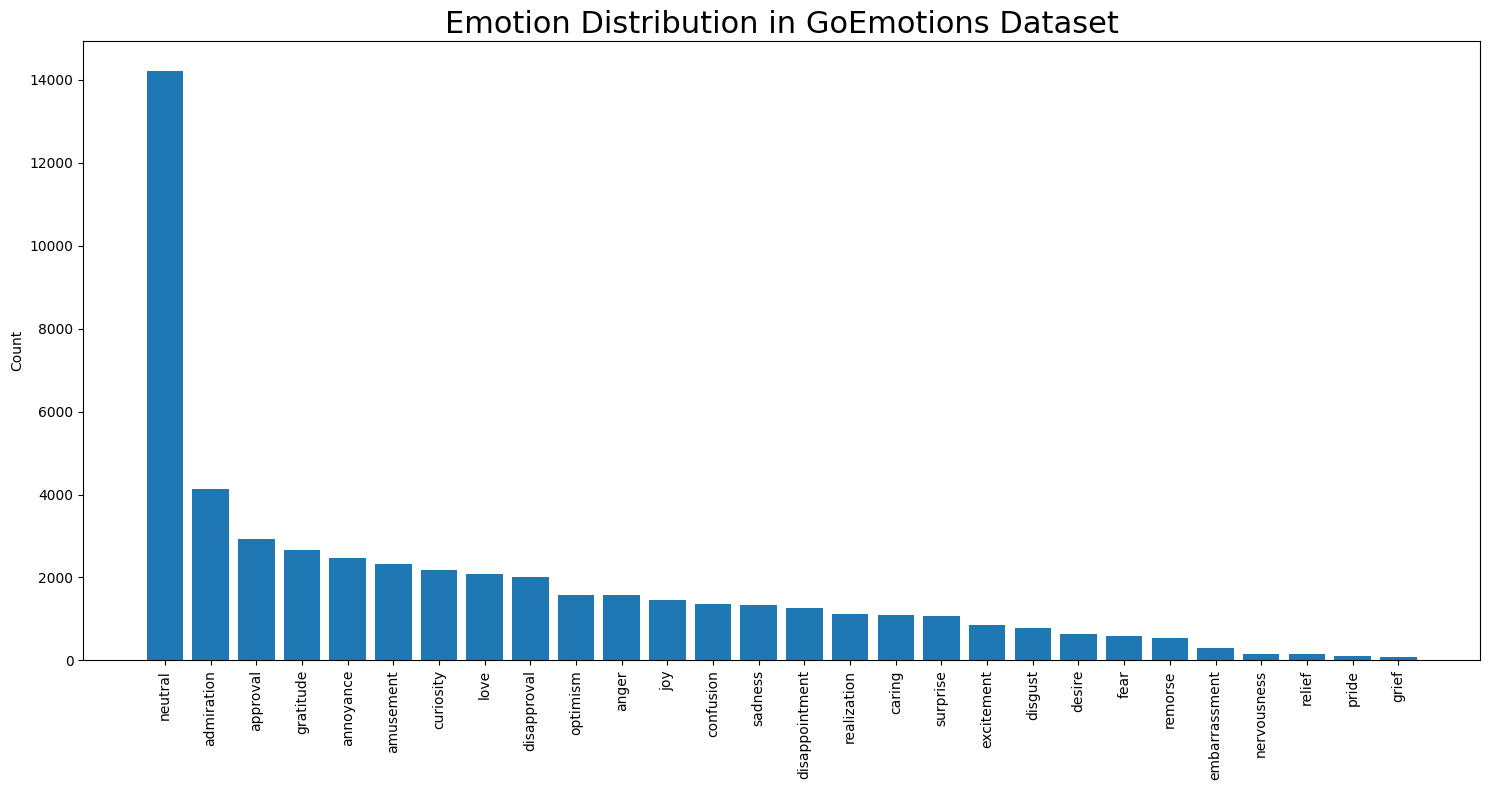

In [4]:
# Analyze label distribution in GoEmotions
def plot_emotion_distribution(dataset, labels_list, name):
    # Count occurrences of each emotion
    emotion_counts = {}
    for example in dataset["train"]:
        for label in example["labels"]:
            if labels_list[label] in emotion_counts:
                emotion_counts[labels_list[label]] += 1
            else:
                emotion_counts[labels_list[label]] = 1
    
    # Sort by frequency
    sorted_emotions = sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)
    emotions = [item[0] for item in sorted_emotions]
    counts = [item[1] for item in sorted_emotions]
    
    # Plot
    plt.figure(figsize=(15, 8))
    plt.bar(emotions, counts)
    plt.xticks(rotation=90)
    plt.title(f'Emotion Distribution in {name} Dataset', fontsize=22)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    return emotion_counts

go_emotions_distribution = plot_emotion_distribution(go_emotions, go_emotions_labels, "GoEmotions")

### 2. ISEAR Dataset

In [5]:
# Load ISEAR dataset
isear_dataset = load_dataset("gsri-18/ISEAR-dataset-complete")

ISEAR_dataset_complete.csv:   0%|          | 0.00/958k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7516 [00:00<?, ? examples/s]

In [6]:
# Explore ISEAR dataset
print("\nISEAR dataset structure:")
print(isear_dataset)
print("\nSample from ISEAR:")
print(isear_dataset["train"].select([0, 1, 2]))


ISEAR dataset structure:
DatasetDict({
    train: Dataset({
        features: ['emotion', 'content', 'Unnamed: 2'],
        num_rows: 7516
    })
})

Sample from ISEAR:
Dataset({
    features: ['emotion', 'content', 'Unnamed: 2'],
    num_rows: 3
})


### Analysis on ISEAR Dataset Distribution

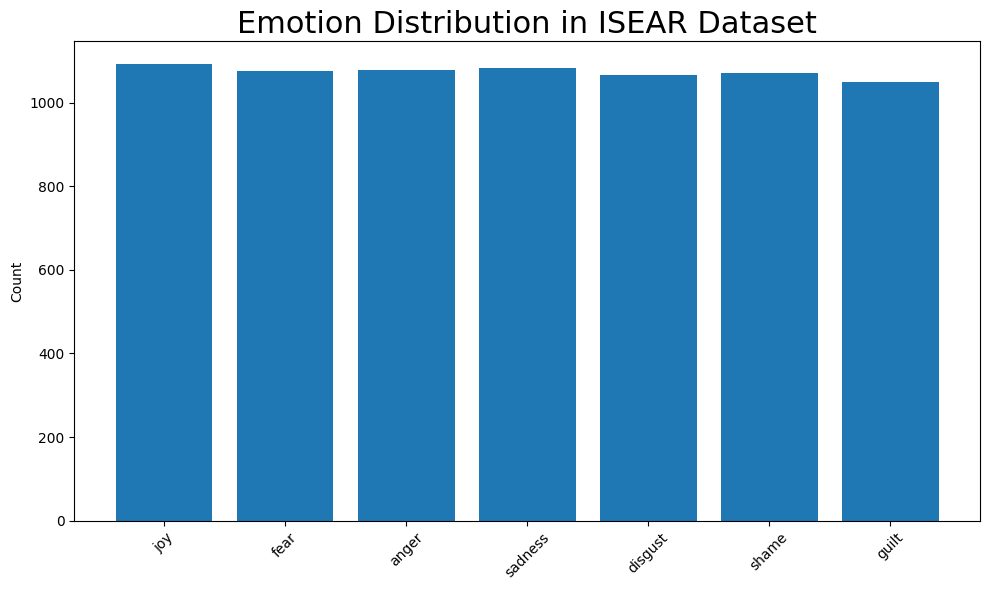

In [7]:
isear_emotions = isear_dataset["train"].unique("emotion")
isear_emotion_counts = {}
for emotion in isear_emotions:
    count = len([ex for ex in isear_dataset["train"] if ex["emotion"] == emotion])
    isear_emotion_counts[emotion] = count

plt.figure(figsize=(10, 6))
plt.bar(isear_emotion_counts.keys(), isear_emotion_counts.values())
plt.title('Emotion Distribution in ISEAR Dataset', fontsize=22)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Preprocessing and Unification

### Define our target emotions for Kumora
We'll focus on a subset of emotions most relevant for women's support.

In [8]:
TARGET_EMOTIONS = [
    "joy", "sadness", "anger", "fear", "surprise", "disgust", "shame", 
    "guilt", "anxiety", "love", "gratitude", "relief"
]
what about prompts? already?kaile?
# Create a mapping from GoEmotions labels to our target emotions
GO_EMOTIONS_MAPPING = {
    "admiration": "love",
    "amusement": "joy",
    "anger": "anger",
    "annoyance": "anger",
    "approval": "gratitude",
    "caring": "love",
    "confusion": "surprise",
    "curiosity": "surprise",
    "desire": "love",
    "disappointment": "sadness",
    "disapproval": "disgust",
    "disgust": "disgust",
    "embarrassment": "shame",
    "excitement": "joy",
    "fear": "fear",
    "gratitude": "gratitude",
    "grief": "sadness",
    "joy": "joy",
    "love": "love",
    "nervousness": "anxiety",
    "optimism": "joy",
    "pride": "joy",
    "realization": "surprise",
    "relief": "relief",
    "remorse": "guilt",
    "sadness": "sadness",
    "surprise": "surprise",
    "neutral": None  # We'll filter out neutral examples
}

# Create a mapping from ISEAR emotions to our target emotions
ISEAR_MAPPING = {
    "joy": "joy",
    "fear": "fear",
    "anger": "anger",
    "sadness": "sadness",
    "disgust": "disgust",
    "shame": "shame",
    "guilt": "guilt"
}

## Function to Preprocess GoEmotions Dataset

In [9]:
# Preprocess GoEmotions dataset
def preprocess_go_emotions(dataset):
    text = dataset["text"]
    
    # Get all emotions for this dataset
    emotions = [go_emotions_labels[label] for label in dataset["labels"]]
    
    # Map to our target emotions, filtering out None values
    mapped_emotions = [GO_EMOTIONS_MAPPING[emotion] for emotion in emotions if emotion in GO_EMOTIONS_MAPPING and GO_EMOTIONS_MAPPING[emotion] is not None]
    
    # Skip dataset with no mapped emotions
    if not mapped_emotions:
        return None
    
    # Take the first mapped emotion if multiple exist
    primary_emotion = mapped_emotions[0]
    
    return {
        "text": text,
        "emotion": primary_emotion
    }

In [10]:
# Process GoEmotions dataset
go_emotions_processed = []
for example in tqdm(go_emotions["train"]):
    processed = preprocess_go_emotions(example)
    if processed:
        go_emotions_processed.append(processed)

go_emotions_processed[:5]

  0%|          | 0/43410 [00:00<?, ?it/s]

[{'text': 'WHY THE FUCK IS BAYLESS ISOING', 'emotion': 'anger'},
 {'text': 'To make her feel threatened', 'emotion': 'fear'},
 {'text': 'Dirty Southern Wankers', 'emotion': 'anger'},
 {'text': "OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.",
  'emotion': 'surprise'},
 {'text': 'Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝',
  'emotion': 'gratitude'}]

In [11]:
# Process ISEAR dataset
isear_processed = []
for example in tqdm(isear_dataset["train"]):
    if example["emotion"] in ISEAR_MAPPING:
        isear_processed.append({
            "text": example["content"],  # description
            "emotion": ISEAR_MAPPING[example["emotion"]]
        })

  0%|          | 0/7516 [00:00<?, ?it/s]

In [12]:
isear_processed[:5]

[{'text': 'On days when I feel close to my partner and other friends.   \nWhen I feel at peace with myself and also experience a close  \ncontact with people whom I regard greatly.',
  'emotion': 'joy'},
 {'text': 'Every time I imagine that someone I love or I could contact a  \nserious illness, even death.',
  'emotion': 'fear'},
 {'text': 'When I had been obviously unjustly treated and had no possibility  \nof elucidating this.',
  'emotion': 'anger'},
 {'text': 'When I think about the short time that we live and relate it to  \nthe periods of my life when I think that I did not use this  \nshort time.',
  'emotion': 'sadness'},
 {'text': 'At a gathering I found myself involuntarily sitting next to two  \npeople who expressed opinions that I considered very low and  \ndiscriminating.',
  'emotion': 'disgust'}]

In [13]:
# Combine datasets
combined_data = go_emotions_processed + isear_processed
print(f"Combined dataset size: {len(combined_data)} examples")

Combined dataset size: 38103 examples


In [14]:
# Convert to DataFrame for easier handling
combined_df = pd.DataFrame(combined_data)

# Check class distribution
emotion_counts = combined_df["emotion"].value_counts()
print("\nEmotion distribution in combined dataset:")
print(emotion_counts)


Emotion distribution in combined dataset:
emotion
love         7172
joy          6080
anger        4764
gratitude    4692
surprise     4489
disgust      3297
sadness      3049
fear         1586
guilt        1454
shame        1319
anxiety       105
relief         96
Name: count, dtype: int64


In [15]:
combined_df.to_csv("collected_emotion_data.csv")

In [2]:
combined_df = pd.read_csv("collected_emotion_data.csv")

In [3]:
combined_df

,Unnamed: 0,text,emotion
0,0,WHY THE FUCK IS BAYLESS ISOING,anger
1,1,To make her feel threatened,fear
2,2,Dirty Southern Wankers,anger
3,3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,surprise
4,4,Yes I heard abt the f bombs! That has to be wh...,gratitude
...,...,...,...
38098,38098,Two years back someone invited me to be the tu...,shame
38099,38099,I had taken the responsibility to do something...,shame
38100,38100,I was at home and I heard a loud sound of spit...,fear
38101,38101,I did not do the homework that the teacher had...,guilt


In [46]:
# Plot the distribution
def plot_distribution(counts, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(title)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

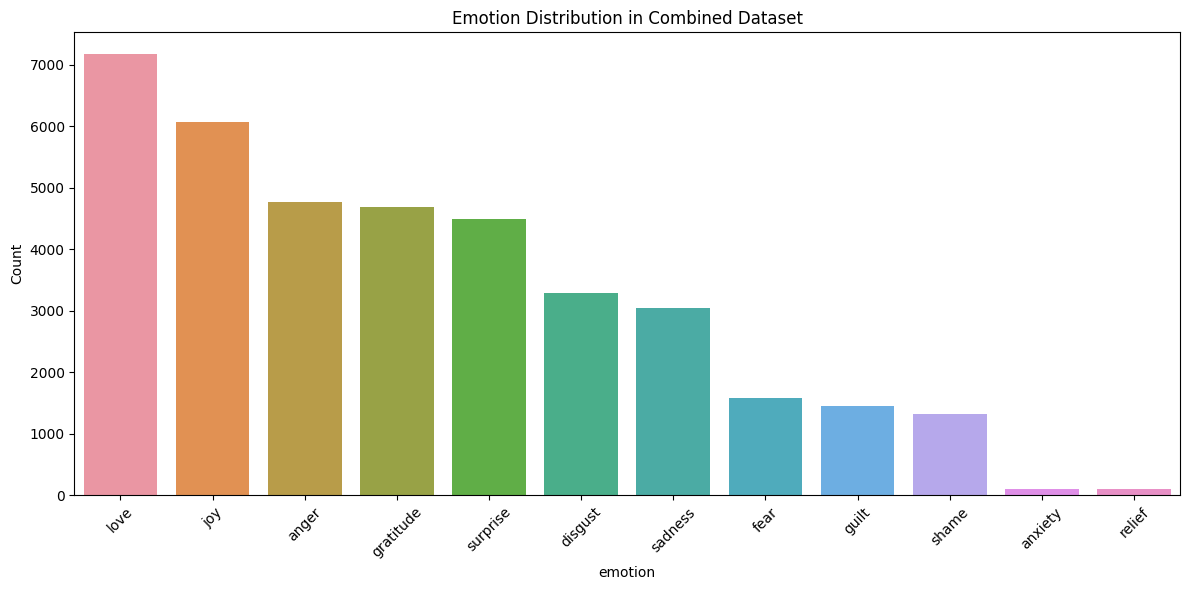

In [17]:
plot_distribution(emotion_counts, title="Emotion Distribution in Combined Dataset")

## Handling Class Imbalance
For now, let's cap the maximum samples per class to avoid extreme imbalance

Balanced dataset size: 34851 examples.

Balanced emotion distribution:
emotion
love         5000
joy          5000
anger        4764
gratitude    4692
surprise     4489
disgust      3297
sadness      3049
fear         1586
guilt        1454
shame        1319
anxiety       105
relief         96
Name: count, dtype: int64


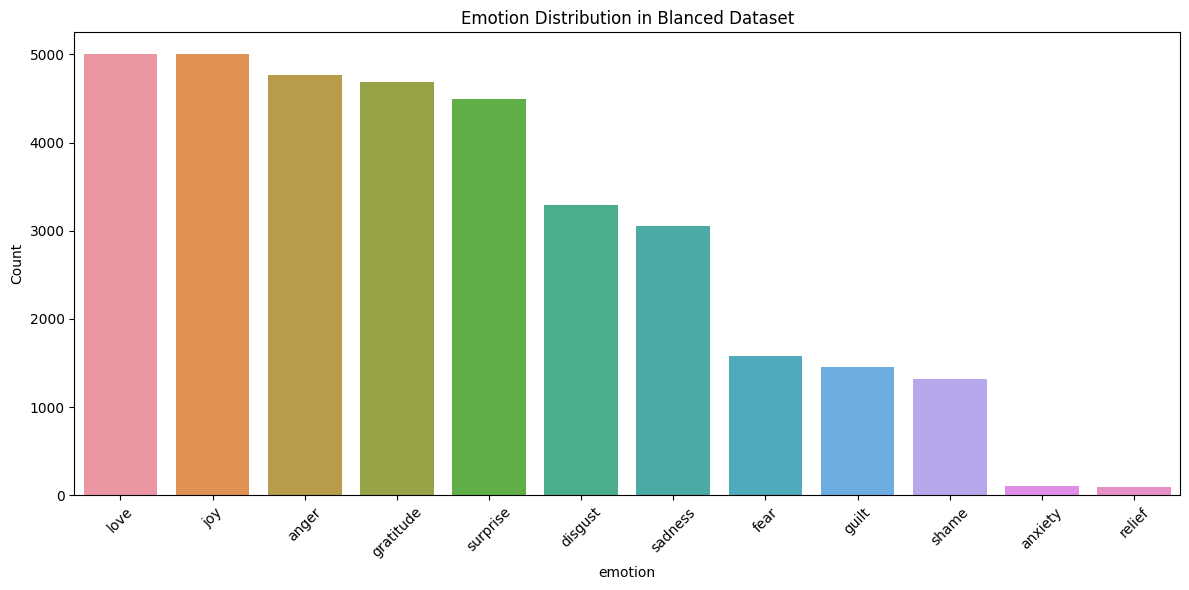

In [22]:
max_samples_per_class = 5000
balanced_data = []

for emotion in TARGET_EMOTIONS:
    samples = df[df["emotion"] == emotion]
    if len(samples) > max_samples_per_class:
        samples = samples.sample(max_samples_per_class, random_state=42)
    balanced_data.append(samples)

balanced_df = pd.concat(balanced_data)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

balanced_emotion_counts = balanced_df["emotion"].value_counts()

print(f"Balanced dataset size: {len(balanced_df)} examples.")

print("\nBalanced emotion distribution:")
print(balanced_emotion_counts)
plot_distribution(balanced_emotion_counts, title="Emotion Distribution in Blanced Dataset")

In [22]:
# Split into train, validation, and test sets
train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df["emotion"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["emotion"], random_state=42)

print(f"Training set: {len(train_df)} examples")
print(f"Validation set: {len(val_df)} examples")
print(f"Test set: {len(test_df)} examples")

# Verify distribution in splits
print("\nEmotion distribution in train set:")
print(train_df["emotion"].value_counts(normalize=True))

print("\nEmotion distribution in validation set:")
print(val_df["emotion"].value_counts(normalize=True))
print("\nEmotion distribution in test set:")
print(test_df["emotion"].value_counts(normalize=True))

Training set: 26672 examples
Validation set: 5715 examples
Test set: 5716 examples

Emotion distribution in train set:
emotion
love         0.188212
joy          0.159568
anger        0.125037
gratitude    0.123163
surprise     0.117801
disgust      0.086533
sadness      0.080009
fear         0.041617
guilt        0.038167
shame        0.034606
anxiety      0.002774
relief       0.002512
Name: proportion, dtype: float64

Emotion distribution in validation set:
emotion
love         0.188276
joy          0.159580
anger        0.124934
gratitude    0.123010
surprise     0.117760
disgust      0.086439
sadness      0.080140
fear         0.041645
guilt        0.038145
shame        0.034646
anxiety      0.002800
relief       0.002625
Name: proportion, dtype: float64

Emotion distribution in test set:
emotion
love         0.188244
joy          0.159552
anger        0.125087
gratitude    0.123163
surprise     0.117915
disgust      0.086599
sadness      0.079951
fear         0.041638
guilt      

In [4]:
# Define the mapping from basic emotions to women's health specific emotions
EMOTION_MAPPING = {
    "joy": ["Improved mood", "Hopefulness", "Renewed energy", "Optimism", 
            "Productivity", "Clarity", "Confidence", "High energy", 
            "Sociability", "Empowerment", "Motivation"],
    
    "sadness": ["Sadness", "Tearfulness", "Low self-esteem", 
                "Loneliness or Isolation", "Feeling overwhelmed"],
    
    "anger": ["Anger or frustration", "Irritability", "Mood swings"],
    
    "fear": ["Anxiety", "Sensitivity to rejection", "Feeling overwhelmed"],
    
    "anxiety": ["Anxiety", "Restlessness", "Feeling overwhelmed", 
                "Emotional sensitivity", "Physical discomfort"],
    
    "shame": ["Low self-esteem", "Sensitivity to rejection", 
              "Loneliness or Isolation"],
    
    "guilt": ["Low self-esteem", "Feeling overwhelmed", "Anxiety"],
    
    "love": ["Attractiveness", "Empowerment", "Sexual drive", 
             "Confidence", "Sociability"],
    
    "gratitude": ["Improved mood", "Hopefulness", "Optimism", 
                  "Feeling in control"],
    
    "relief": ["Clarity", "Feeling in control", "Renewed energy", 
               "Improved mood"],
    
    "surprise": ["Mood swings", "Emotional sensitivity"],
    
    "disgust": ["Physical discomfort", "Low self-esteem", "Irritability"]
}

In [5]:
# Create reverse mapping for easier lookup
REVERSE_EMOTION_MAPPING = {}
for basic_emotion, specific_emotions in EMOTION_MAPPING.items():
    for specific_emotion in specific_emotions:
        if specific_emotion not in REVERSE_EMOTION_MAPPING:
            REVERSE_EMOTION_MAPPING[specific_emotion] = []
        REVERSE_EMOTION_MAPPING[specific_emotion].append(basic_emotion)

In [18]:
all_wh_emotions = sorted(list(set(
        emotion for emotions in EMOTION_MAPPING.values() 
        for emotion in emotions
    )))
all_wh_emotions

['Anger or frustration',
 'Anxiety',
 'Attractiveness',
 'Clarity',
 'Confidence',
 'Emotional sensitivity',
 'Empowerment',
 'Feeling in control',
 'Feeling overwhelmed',
 'High energy',
 'Hopefulness',
 'Improved mood',
 'Irritability',
 'Loneliness or Isolation',
 'Low self-esteem',
 'Mood swings',
 'Motivation',
 'Optimism',
 'Physical discomfort',
 'Productivity',
 'Renewed energy',
 'Restlessness',
 'Sadness',
 'Sensitivity to rejection',
 'Sexual drive',
 'Sociability',
 'Tearfulness']

In [27]:
def transform_basic_to_multilabel(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform single-label basic emotions to multi-label women's health emotions
    """
    transformed_data = []

    # Get all unique women's health emotions
    all_wh_emotions = sorted(list(set(
        emotion for emotions in EMOTION_MAPPING.values() 
        for emotion in emotions
    )))
    
    for idx, row in df.iterrows():
        text = row['text']
        basic_emotion = row['emotion']
        
        # Create multi-label representation initialized to 0
        emotion_labels = {emotion: 0 for emotion in all_wh_emotions}
        
        # Get mapped emotions for this basic emotion
        if basic_emotion in EMOTION_MAPPING:
            wh_emotions = EMOTION_MAPPING[basic_emotion]
            
            # Set corresponding emotions to 1
            for wh_emotion in wh_emotions:
                emotion_labels[wh_emotion] = 1
        
        transformed_data.append({
            'text': text,
            'emotions': emotion_labels
        })
    
    return pd.DataFrame(transformed_data)

# 1. Transform existing data

In [28]:
print("Transforming basic emotion data to multi-label...")
multilabel_dataset = transform_basic_to_multilabel(combined_df)

Transforming basic emotion data to multi-label...


In [29]:
len(multilabel_dataset)

38103

In [30]:
multilabel_dataset["emotions"][6]

{'Anger or frustration': 0,
 'Anxiety': 0,
 'Attractiveness': 1,
 'Clarity': 0,
 'Confidence': 1,
 'Emotional sensitivity': 0,
 'Empowerment': 1,
 'Feeling in control': 0,
 'Feeling overwhelmed': 0,
 'High energy': 0,
 'Hopefulness': 0,
 'Improved mood': 0,
 'Irritability': 0,
 'Loneliness or Isolation': 0,
 'Low self-esteem': 0,
 'Mood swings': 0,
 'Motivation': 0,
 'Optimism': 0,
 'Physical discomfort': 0,
 'Productivity': 0,
 'Renewed energy': 0,
 'Restlessness': 0,
 'Sadness': 0,
 'Sensitivity to rejection': 0,
 'Sexual drive': 1,
 'Sociability': 1,
 'Tearfulness': 0}

In [38]:
import random
from typing import Dict, List, Tuple

class WomensHealthDataGenerator:
    def __init__(self):
        self.scenarios = self._load_scenarios()
        self.emotion_combinations = self._define_emotion_combinations()
    
    def _load_scenarios(self) -> Dict[str, List[str]]:
        """Define scenario templates for different women's health contexts"""
        return {
            "menstrual_phase": {
                "follicular": [
                    "I'm feeling so energetic today, like I could conquer the world! My skin is glowing and I actually want to go out tonight.",
                    "Finally feeling clear-headed after last week. I'm ready to tackle that project I've been putting off.",
                    "Woke up feeling optimistic about everything. Maybe it's just my hormones, but I'll take it!"
                ],
                "ovulation": [
                    "Feeling incredibly confident and attractive today. Is this what they mean by ovulation glow?",
                    "My energy is through the roof and I feel so social. Called three friends just to chat!",
                    "Everything feels possible today. Started two new projects and signed up for that class."
                ],
                "luteal": [
                    "Why am I crying at this commercial? I know it's just PMS but these emotions feel so real.",
                    "Feeling irritable and bloated. Just want to hide under a blanket with chocolate.",
                    "My anxiety is through the roof today. Everything feels overwhelming and I can't focus."
                ],
                "menstrual": [
                    "Cramps are killing me and I feel so emotional. Called in sick because I just can't today.",
                    "Feeling drained but also weirdly relieved that my period finally came. Time for self-care.",
                    "The pain is manageable today but I'm exhausted. Grateful for a quiet day at home."
                ]
            },
            "life_transitions": [
                "Starting this new job has me feeling anxious but also hopeful. It's scary and exciting at the same time.",
                "Becoming a mom has brought so many emotions - joy, fear, overwhelming love, and complete exhaustion.",
                "Going through menopause and these mood swings are intense. One moment I'm fine, the next I'm furious."
            ],
            "relationships": [
                "Had a fight with my partner and feeling so hurt and misunderstood. Why is communication so hard?",
                "My best friend just gets me. After our talk, I feel supported and understood.",
                "Dating in my 30s is exhausting. Feeling lonely but trying to stay hopeful."
            ],
            "self_care": [
                "Took a mental health day and already feeling more in control. Sometimes you just need to pause.",
                "Finally went to therapy and feeling vulnerable but proud of myself for taking this step.",
                "Started exercising again and the endorphins are real! Feeling motivated and strong."
            ]
        }
    
    def _define_emotion_combinations(self) -> Dict[str, List[str]]:
        """Define realistic emotion combinations for different scenarios"""
        return {
            "pms_emotional": ["Mood swings", "Irritability", "Anxiety", "Tearfulness", 
                            "Emotional sensitivity", "Physical discomfort"],
            "pms_physical": ["Physical discomfort", "Low self-esteem", "Irritability", 
                           "Feeling overwhelmed"],
            "ovulation_positive": ["High energy", "Confidence", "Sexual drive", 
                                 "Attractiveness", "Sociability", "Empowerment"],
            "menstrual_mixed": ["Physical discomfort", "Tearfulness", "Relief", 
                              "Feeling overwhelmed", "Low self-esteem"],
            "stress_anxiety": ["Anxiety", "Feeling overwhelmed", "Restlessness", 
                             "Emotional sensitivity", "Irritability"],
            "empowerment": ["Confidence", "Empowerment", "Motivation", "Clarity", 
                          "Feeling in control", "Optimism"],
            "emotional_support": ["Gratitude", "Hopefulness", "Relief", 
                                "Improved mood", "Feeling in control"],
            "loneliness": ["Loneliness or Isolation", "Sadness", "Low self-esteem", 
                         "Sensitivity to rejection"]
        }
    
    def generate_samples(self, n_samples: int = 1000) -> List[Dict]:
        """Generate synthetic women's health data samples"""
        samples = []
        
        for _ in range(n_samples):
            # Choose scenario category
            category = random.choice(list(self.scenarios.keys()))
            
            if category == "menstrual_phase":
                phase = random.choice(list(self.scenarios[category].keys()))
                texts = self.scenarios[category][phase]
                
                # Select appropriate emotion combination
                if phase == "luteal":
                    emotion_combo = random.choice(["pms_emotional", "pms_physical", "stress_anxiety"])
                elif phase == "ovulation":
                    emotion_combo = "ovulation_positive"
                elif phase == "menstrual":
                    emotion_combo = "menstrual_mixed"
                else:  # follicular
                    emotion_combo = random.choice(["empowerment", "emotional_support"])
            else:
                texts = self.scenarios[category]
                emotion_combo = random.choice(list(self.emotion_combinations.keys()))
            
            # Generate text (with variations)
            base_text = random.choice(texts)
            text = self._add_variations(base_text)
            
            # Assign emotions
            emotions = self._assign_emotions(emotion_combo)
            
            samples.append({
                'text': text,
                'emotions': emotions
            })
        
        return samples
    
    def _add_variations(self, text: str) -> str:
        """Add variations to make text more diverse"""
        variations = [
            ("feeling", random.choice(["feeling", "feel", "experiencing", "going through"])),
            ("today", random.choice(["today", "right now", "at the moment", "lately"])),
            ("so", random.choice(["so", "really", "incredibly", "quite", "very"]))
        ]
        
        for original, replacement in variations:
            if original in text and random.random() > 0.5:
                text = text.replace(original, replacement, 1)
        
        return text
    
    def _assign_emotions(self, emotion_combo: str) -> Dict[str, int]:
        """Assign emotions based on combination with some randomness"""
        all_emotions = list(REVERSE_EMOTION_MAPPING.keys())
        emotion_labels = {emotion: 0 for emotion in all_emotions}
        
        # Get base emotions for this combination
        base_emotions = self.emotion_combinations[emotion_combo]
        
        # Assign primary emotions (high probability)
        for emotion in base_emotions:
            if random.random() > 0.2:  # 80% chance
                emotion_labels[emotion] = 1
        
        # Add some random secondary emotions (low probability)
        for emotion in all_emotions:
            if emotion not in base_emotions and random.random() > 0.95:  # 5% chance
                emotion_labels[emotion] = 1
        
        return emotion_labels

## 2. Generate synthetic data

In [39]:
NUM_SYNTHETIC = 5000

print(f"Generating {NUM_SYNTHETIC} synthetic samples...")
generator = WomensHealthDataGenerator()
synthetic_samples = generator.generate_samples(NUM_SYNTHETIC)
synthetic_df = pd.DataFrame(synthetic_samples)

Generating 5000 synthetic samples...


In [40]:
print(f"The length of synthetic data: {len(synthetic_df)}.")

The length of synthetic data: 5000.


In [41]:
synthetic_df.head()

,text,emotions
0,Becoming a mom has brought so many emotions - ...,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe..."
1,Finally went to therapy and feel vulnerable bu...,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe..."
2,Started exercising again and the endorphins ar...,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe..."
3,Becoming a mom has brought so many emotions - ...,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe..."
4,Finally went to therapy and feel vulnerable bu...,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe..."


In [42]:
synthetic_df["emotions"][6]

{'Improved mood': 1,
 'Hopefulness': 1,
 'Renewed energy': 0,
 'Optimism': 0,
 'Productivity': 0,
 'Clarity': 0,
 'Confidence': 0,
 'High energy': 0,
 'Sociability': 0,
 'Empowerment': 0,
 'Motivation': 0,
 'Sadness': 0,
 'Tearfulness': 0,
 'Low self-esteem': 0,
 'Loneliness or Isolation': 0,
 'Feeling overwhelmed': 0,
 'Anger or frustration': 1,
 'Irritability': 0,
 'Mood swings': 0,
 'Anxiety': 0,
 'Sensitivity to rejection': 0,
 'Restlessness': 0,
 'Emotional sensitivity': 0,
 'Physical discomfort': 0,
 'Attractiveness': 1,
 'Sexual drive': 0,
 'Feeling in control': 1,
 'Gratitude': 1,
 'Relief': 1}

## 3. Combine datasets

In [47]:
final_df = pd.concat([transformed_df, synthetic_df], ignore_index=True)

# Convert emotion dict to separate columns
emotion_columns = list(REVERSE_EMOTION_MAPPING.keys())
for emotion in emotion_columns:
    final_df[emotion] = final_df['emotions'].apply(lambda x: x[emotion])

# 5. Add metadata
final_df['total_emotions'] = final_df[emotion_columns].sum(axis=1)
final_df['primary_emotion'] = final_df[emotion_columns].idxmax(axis=1)

print(f"Final dataset size: {len(final_df)}")

Final dataset size: 43103


In [3]:
final_df.head()

,Unnamed: 0,text,emotions,Improved mood,Hopefulness,Renewed energy,Optimism,Productivity,Clarity,Confidence,...,Anxiety,Sensitivity to rejection,Restlessness,Emotional sensitivity,Physical discomfort,Attractiveness,Sexual drive,Feeling in control,total_emotions,primary_emotion
0,0,WHY THE FUCK IS BAYLESS ISOING,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Anger or frustration
1,1,To make her feel threatened,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe...",0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,3,Feeling overwhelmed
2,2,Dirty Southern Wankers,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Anger or frustration
3,3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe...",0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,Emotional sensitivity
4,4,Yes I heard abt the f bombs! That has to be wh...,"{'Improved mood': 0, 'Hopefulness': 0, 'Renewe...",0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,2,Optimism


In [52]:
# Plot the distribution
def plot_distribution(counts, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(title)
    plt.ylabel('Count')
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()

In [51]:
final_emotions_count = final_df[emotion_columns].sum().sort_values(ascending=False)
print(f"Emotion distribution:\n{final_emotions_count}")

Emotion distribution:
Empowerment                 9315
Confidence                  9247
Sociability                 8786
Optimism                    7178
Improved mood               7162
Hopefulness                 7127
Low self-esteem             7052
Irritability                6383
Mood swings                 6213
Feeling overwhelmed         5426
Attractiveness              5148
Sexual drive                5125
High energy                 4525
Clarity                     4454
Motivation                  4372
Feeling in control          4033
Renewed energy              3941
Emotional sensitivity       3870
Productivity                3851
Physical discomfort         3703
Loneliness or Isolation     3240
Tearfulness                 3145
Anger or frustration        3095
Anxiety                     3022
Sadness                     2416
Sensitivity to rejection    2352
Restlessness                 783
dtype: int64


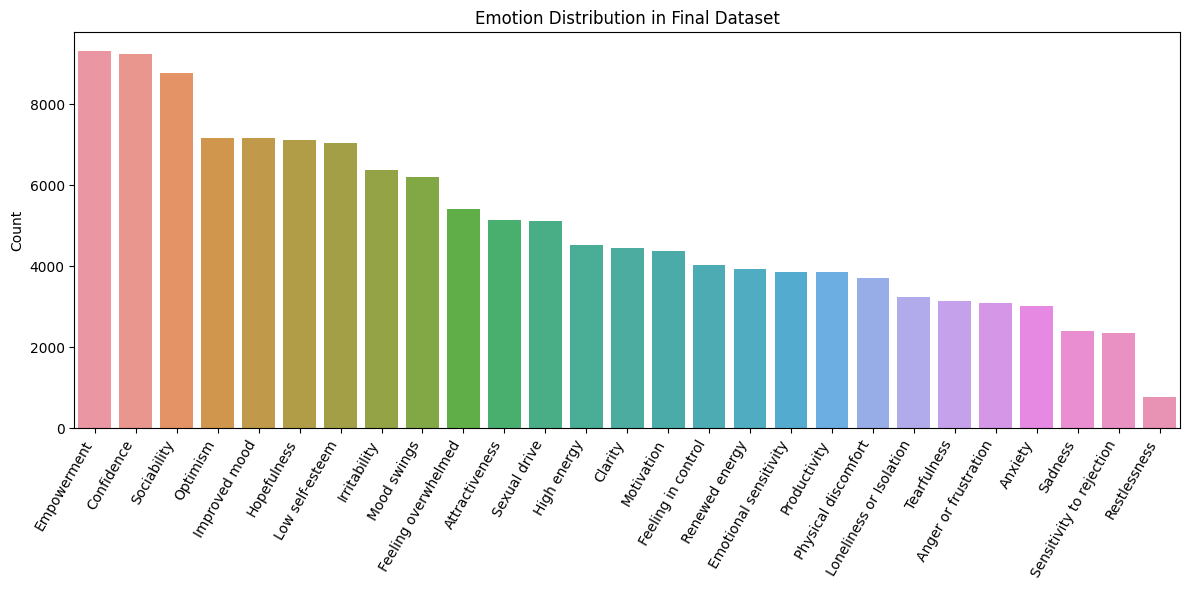

In [53]:
plot_distribution(final_emotions_count, title="Emotion Distribution in Final Dataset")

In [54]:
final_df.to_csv("final_emotions_data.csv")

In [2]:
final_df = pd.read_csv("final_emotions_data.csv")

In [57]:
all_emotions = sorted(list(set(
        emotion for emotions in EMOTION_MAPPING.values() 
        for emotion in emotions
    )))
all_emotions

['Anger or frustration',
 'Anxiety',
 'Attractiveness',
 'Clarity',
 'Confidence',
 'Emotional sensitivity',
 'Empowerment',
 'Feeling in control',
 'Feeling overwhelmed',
 'High energy',
 'Hopefulness',
 'Improved mood',
 'Irritability',
 'Loneliness or Isolation',
 'Low self-esteem',
 'Mood swings',
 'Motivation',
 'Optimism',
 'Physical discomfort',
 'Productivity',
 'Renewed energy',
 'Restlessness',
 'Sadness',
 'Sensitivity to rejection',
 'Sexual drive',
 'Sociability',
 'Tearfulness']

In [58]:
labels = final_df[all_emotions].values
labels

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Initialize Training and Evaluation Pipeline

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split

## Custom Torch Dataset Class for Emotions

In [15]:
class EmotionDataset(Dataset):
    def __init__(self, texts: List[str], labels: np.ndarray, tokenizer, max_length: int = 256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }

## Prepare the DataLoaders

In [16]:
def prepare_data_loaders(df: pd.DataFrame, tokenizer, emotion_columns: List[str], 
                        batch_size: int = 16, test_size: float = 0.2, val_size: float = 0.1):
    """
    Prepare train, validation, and test data loaders
    """
    # Extract texts and labels
    texts = df['text'].values
    labels = df[emotion_columns].values
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        texts, labels, test_size=test_size, random_state=42, 
        stratify=df['basic_emotion'] if 'basic_emotion' in df.columns else None
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=42
    )
    
    # Create datasets
    train_dataset = EmotionDataset(X_train, y_train, tokenizer)
    val_dataset = EmotionDataset(X_val, y_val, tokenizer)
    test_dataset = EmotionDataset(X_test, y_test, tokenizer)

    print(f"Length of Training Set:\t\t{len(train_dataset)}")
    print(f"Length of Validation Set:\t{len(val_dataset)}")
    print(f"Length of Testing Set:\t\t{len(test_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Multi-Label Emotion Classifier

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class KumoraEmotionClassifier(nn.Module):
    def __init__(self, 
                 model_name: str, 
                 num_labels: int,
                 emotion_names: List[str],
                 dropout: float = 0.3,
                 use_attention: bool = True):
        super().__init__()
        
        self.model_name = model_name
        self.num_labels = num_labels
        self.emotion_names = emotion_names
        self.use_attention = use_attention
        
        # Load pre-trained transformer
        self.transformer = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.transformer.config.hidden_size
        
        # Freeze early layers for efficiency (optional)
        # for param in self.transformer.embeddings.parameters():
        #     param.requires_grad = False
        
        self.dropout = nn.Dropout(dropout)
        
        if self.use_attention:
            # Multi-head attention for emotion interactions
            self.emotion_attention = nn.MultiheadAttention(
                embed_dim=self.hidden_size,
                num_heads=8,
                dropout=dropout,
                batch_first=True
            )
            
            # Emotion embedding layer for attention
            self.emotion_embeddings = nn.Embedding(num_labels, self.hidden_size)
        
        # Classification head with residual connections
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_labels)
        )
        
        # Emotion-specific thresholds (learnable)
        self.thresholds = nn.Parameter(torch.ones(num_labels) * 0.5)
    
    def forward(self, input_ids, attention_mask, return_attention=False):
        # Get transformer outputs
        outputs = self.transformer(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        
        # Use pooled output from last hidden state
        # You can also experiment with mean pooling or last 4 layers
        pooled_output = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        # Alternative: pooled_output = outputs.pooler_output  # CLS token
        
        if self.use_attention:
            # Create emotion queries
            emotion_indices = torch.arange(self.num_labels).to(input_ids.device)
            emotion_queries = self.emotion_embeddings(emotion_indices)
            emotion_queries = emotion_queries.unsqueeze(0).repeat(pooled_output.size(0), 1, 1)
            
            # Apply attention
            pooled_output_expanded = pooled_output.unsqueeze(1).repeat(1, self.num_labels, 1)
            attended_output, attention_weights = self.emotion_attention(
                emotion_queries,
                pooled_output_expanded,
                pooled_output_expanded
            )
            
            # Combine with original representation
            pooled_output = pooled_output + attended_output.mean(dim=1)
        else:
            attention_weights = None
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Get logits
        logits = self.classifier(pooled_output)
        
        if return_attention and attention_weights is not None:
            return logits, attention_weights
        
        return logits
    
    def predict(self, input_ids, attention_mask, threshold=None):
        """Get predictions with custom or learned thresholds"""
        logits = self.forward(input_ids, attention_mask)
        probs = torch.sigmoid(logits)
        
        if threshold is None:
            # Use learned thresholds
            threshold = torch.sigmoid(self.thresholds)
        
        predictions = (probs > threshold).float()
        
        return predictions, probs

## Training Function with Advanced Features

In [18]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_recall_fscore_support, hamming_loss
from tqdm import tqdm
import wandb  # Optional: for experiment tracking

class EmotionClassifierTrainer:
    def __init__(self, 
                 model: KumoraEmotionClassifier,
                 device: torch.device,
                 learning_rate: float = 2e-5,
                 weight_decay: float = 0.01,
                 use_class_weights: bool = True):
        
        self.model = model.to(device)
        self.device = device
        
        # Optimizer with different learning rates for transformer and classifier
        transformer_params = list(model.transformer.parameters())
        classifier_params = list(model.classifier.parameters()) + [model.thresholds]
        
        if model.use_attention:
            classifier_params.extend(list(model.emotion_attention.parameters()))
            classifier_params.extend(list(model.emotion_embeddings.parameters()))
        
        self.optimizer = optim.AdamW([
            {'params': transformer_params, 'lr': learning_rate},
            {'params': classifier_params, 'lr': learning_rate * 10}
        ], weight_decay=weight_decay)
        
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode='max', patience=3, factor=0.5
        )
        
        self.use_class_weights = use_class_weights
        self.class_weights = None
        
    def compute_class_weights(self, train_loader):
        """Compute class weights for imbalanced data"""
        if not self.use_class_weights:
            return
        
        label_counts = torch.zeros(self.model.num_labels)
        total_samples = 0
        
        for batch in train_loader:
            labels = batch['labels']
            label_counts += labels.sum(dim=0)
            total_samples += labels.size(0)
        
        # Compute weights (inverse frequency)
        weights = total_samples / (self.model.num_labels * label_counts)
        weights = weights / weights.mean()  # Normalize
        
        self.class_weights = weights.to(self.device)
        print(f"Class weights computed: {self.class_weights}")
    
    def train_epoch(self, train_loader, epoch):
        self.model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        progress_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            logits = self.model(input_ids, attention_mask)
            
            # Compute loss with class weights
            if self.class_weights is not None:
                pos_weight = self.class_weights
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            else:
                criterion = nn.BCEWithLogitsLoss()
            
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            predictions = torch.sigmoid(logits) > 0.5
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Calculate metrics
        avg_loss = total_loss / len(train_loader)
        f1_micro = f1_score(all_labels, all_predictions, average='micro')
        f1_macro = f1_score(all_labels, all_predictions, average='macro')
        
        return avg_loss, f1_micro, f1_macro
    
    def evaluate(self, data_loader, phase='Validation'):
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch in tqdm(data_loader, desc=f'{phase}'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                logits = self.model(input_ids, attention_mask)
                
                # Compute loss
                criterion = nn.BCEWithLogitsLoss()
                loss = criterion(logits, labels)
                total_loss += loss.item()
                
                # Get predictions
                probs = torch.sigmoid(logits)
                predictions = probs > 0.5
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate comprehensive metrics
        avg_loss = total_loss / len(data_loader)
        
        # Convert to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        # Calculate metrics
        f1_micro = f1_score(all_labels, all_predictions, average='micro')
        f1_macro = f1_score(all_labels, all_predictions, average='macro')
        f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
        
        # Per-class metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            all_labels, all_predictions, average=None
        )
        
        # Hamming loss (fraction of wrong labels)
        h_loss = hamming_loss(all_labels, all_predictions)
        
        # Subset accuracy (exact match)
        subset_acc = np.mean(np.all(all_predictions == all_labels, axis=1))
        
        metrics = {
            'loss': avg_loss,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'hamming_loss': h_loss,
            'subset_accuracy': subset_acc,
            'per_class_f1': {self.model.emotion_names[i]: f1[i] for i in range(len(f1))},
            'per_class_precision': {self.model.emotion_names[i]: precision[i] for i in range(len(precision))},
            'per_class_recall': {self.model.emotion_names[i]: recall[i] for i in range(len(recall))}
        }
        
        return metrics, all_probs
    
    def train(self, train_loader, val_loader, num_epochs=10, save_path='kumora_emotion_model.pt'):
        # Compute class weights
        self.compute_class_weights(train_loader)
        
        best_f1 = 0
        patience = 0
        max_patience = 5
        
        for epoch in range(num_epochs):
            print(f"\n{'='*50}")
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"{'='*50}")
            
            # Training
            train_loss, train_f1_micro, train_f1_macro = self.train_epoch(train_loader, epoch+1)
            print(f"Train Loss: {train_loss:.4f}, F1 Micro: {train_f1_micro:.4f}, F1 Macro: {train_f1_macro:.4f}")
            
            # Validation
            val_metrics, _ = self.evaluate(val_loader)
            print(f"Val Loss: {val_metrics['loss']:.4f}, F1 Micro: {val_metrics['f1_micro']:.4f}, "
                  f"F1 Macro: {val_metrics['f1_macro']:.4f}, Hamming Loss: {val_metrics['hamming_loss']:.4f}")
            
            # Learning rate scheduling
            self.scheduler.step(val_metrics['f1_macro'])
            
            # Save best model
            if val_metrics['f1_macro'] > best_f1:
                best_f1 = val_metrics['f1_macro']
                patience = 0
                
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_f1': best_f1,
                    'epoch': epoch,
                    'emotion_names': self.model.emotion_names,
                    'model_config': {
                        'model_name': self.model.model_name,
                        'num_labels': self.model.num_labels,
                        'use_attention': self.model.use_attention
                    }
                }, save_path)
                
                print(f"✓ Saved best model with F1 Macro: {best_f1:.4f}")
            else:
                patience += 1
                if patience >= max_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break
        
        print(f"\nTraining completed! Best F1 Macro: {best_f1:.4f}")
        return best_f1

## Inference and Integration with Kumora

In [19]:
class KumoraEmotionAnalyzer:
    def __init__(self, model_path: str, device: torch.device = None):
        if device is None:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.device = device
        
        # Load model configuration and weights
        checkpoint = torch.load(model_path, map_location=device)
        model_config = checkpoint['model_config']
        
        # Initialize model
        self.model = KumoraEmotionClassifier(
            model_name=model_config['model_name'],
            num_labels=model_config['num_labels'],
            emotion_names=checkpoint['emotion_names'],
            use_attention=model_config['use_attention']
        )
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(device)
        self.model.eval()
        
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_config['model_name'])
        self.emotion_names = checkpoint['emotion_names']
    
    def analyze_emotions(self, text: str, threshold: float = 0.5, return_all: bool = False):
        """
        Analyze emotions in text
        
        Args:
            text: Input text to analyze
            threshold: Probability threshold for emotion detection
            return_all: If True, return all emotion probabilities
        
        Returns:
            Dictionary with detected emotions and their probabilities
        """
        # Tokenize input
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=256,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        # Get predictions
        with torch.no_grad():
            predictions, probs = self.model.predict(input_ids, attention_mask, threshold)
        
        # Convert to numpy
        probs = probs.cpu().numpy()[0]
        predictions = predictions.cpu().numpy()[0]
        
        # Create results dictionary
        results = {
            'detected_emotions': [],
            'emotion_scores': {},
            'primary_emotion': None,
            'emotional_intensity': None
        }
        
        # Process emotions
        for i, (emotion, prob, pred) in enumerate(zip(self.emotion_names, probs, predictions)):
            if return_all or pred == 1:
                results['emotion_scores'][emotion] = float(prob)
                if pred == 1:
                    results['detected_emotions'].append(emotion)
        
        # Determine primary emotion (highest probability)
        if results['emotion_scores']:
            results['primary_emotion'] = max(results['emotion_scores'], 
                                            key=results['emotion_scores'].get)
        
        # Calculate emotional intensity (average of detected emotion probabilities)
        if results['detected_emotions']:
            detected_probs = [results['emotion_scores'][em] for em in results['detected_emotions']]
            results['emotional_intensity'] = float(np.mean(detected_probs))
        
        return results
    
    def analyze_conversation(self, messages: List[str]) -> Dict:
        """
        Analyze emotional trajectory across a conversation
        """
        trajectory = []
        
        for message in messages:
            emotion_result = self.analyze_emotions(message, return_all=True)
            trajectory.append(emotion_result)
        
        # Analyze patterns
        primary_emotions = [r['primary_emotion'] for r in trajectory if r['primary_emotion']]
        emotion_counts = {}
        
        for result in trajectory:
            for emotion in result['detected_emotions']:
                emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        
        return {
            'trajectory': trajectory,
            'dominant_emotions': sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)[:3],
            'emotional_stability': self._calculate_stability(trajectory),
            'average_intensity': np.mean([r['emotional_intensity'] for r in trajectory 
                                         if r['emotional_intensity'] is not None])
        }
    
    def _calculate_stability(self, trajectory: List[Dict]) -> float:
        """Calculate emotional stability score (0-1, higher is more stable)"""
        if len(trajectory) < 2:
            return 1.0
        
        # Calculate variance in emotional states
        emotion_vectors = []
        for result in trajectory:
            vector = [result['emotion_scores'].get(em, 0) for em in self.emotion_names]
            emotion_vectors.append(vector)
        
        emotion_vectors = np.array(emotion_vectors)
        
        # Calculate stability as inverse of average variance
        variances = np.var(emotion_vectors, axis=0)
        stability = 1 - np.mean(variances)
        
        return float(stability)

## Complete Training Pipeline

In [20]:
def train_kumora_emotion_classifier(dataset: pd.DataFrame, model_name: str = "distilbert-base-uncased"):
    """
    Complete training pipeline for Kumora emotion classifier
    """
    # Load data
    # df = pd.read_csv(dataset_path)
    
    # Get emotion columns
    all_wh_emotions = sorted(list(set(
        emotion for emotions in EMOTION_MAPPING.values() 
        for emotion in emotions
    )))
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Prepare data loaders
    train_loader, val_loader, test_loader = prepare_data_loaders(
        dataset, tokenizer, all_wh_emotions, batch_size=16
    )
    
    # Initialize model
    model = KumoraEmotionClassifier(
        model_name=model_name,
        num_labels=len(all_wh_emotions),
        emotion_names=all_wh_emotions,
        use_attention=True
    )
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize trainer
    trainer = EmotionClassifierTrainer(
        model=model,
        device=device,
        learning_rate=2e-5,
        use_class_weights=True
    )
    
    # Train model
    best_f1 = trainer.train(
        train_loader, 
        val_loader, 
        num_epochs=10,
        save_path='kumora_emotion_model_best.pt'
    )
    
    # Test evaluation
    print("\n" + "="*50)
    print("FINAL TEST EVALUATION")
    print("="*50)
    
    test_metrics, test_probs = trainer.evaluate(test_loader, phase='Test')
    
    print(f"\nTest Results:")
    print(f"F1 Micro: {test_metrics['f1_micro']:.4f}")
    print(f"F1 Macro: {test_metrics['f1_macro']:.4f}")
    print(f"Hamming Loss: {test_metrics['hamming_loss']:.4f}")
    print(f"Subset Accuracy: {test_metrics['subset_accuracy']:.4f}")
    
    print("\nPer-Emotion F1 Scores:")
    for emotion, f1 in test_metrics['per_class_f1'].items():
        print(f"  {emotion}: {f1:.4f}")
    
    return model, test_metrics

In [ ]:
# Train the model
model, metrics = train_kumora_emotion_classifier(final_df)#('kumora_emotions_dataset.csv')

# Test inference
# analyzer = KumoraEmotionAnalyzer('kumora_emotion_model_best.pt')

# # Example analysis
# test_text = "I'm feeling so overwhelmed with work and these cramps are killing me. Just want to cry."
# result = analyzer.analyze_emotions(test_text)

# print(f"\nText: {test_text}")
# print(f"Detected emotions: {result['detected_emotions']}")
# print(f"Primary emotion: {result['primary_emotion']}")
# print(f"Emotional intensity: {result['emotional_intensity']:.3f}")

Length of Training Set:		30171
Length of Validation Set:	4311
Length of Testing Set:		8621


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Using device: cuda
Class weights computed: tensor([1.2155, 1.2425, 0.7300, 0.8598, 0.4079, 0.9852, 0.4047, 0.9445, 0.6940,
        0.8365, 0.5290, 0.5277, 0.5923, 1.1366, 0.5299, 0.6080, 0.8814, 0.5265,
        1.0173, 0.9972, 0.9703, 4.8732, 1.5254, 1.6174, 0.7296, 0.4252, 1.1923],
       device='cuda:0')

Epoch 1/10


Training Epoch 1: 100%|██████████| 1886/1886 [07:05<00:00,  4.43it/s, loss=0.2428]


Train Loss: 0.2396, F1 Micro: 0.0801, F1 Macro: 0.0942


Validation: 100%|██████████| 270/270 [00:16<00:00, 16.16it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 0.2648, F1 Micro: 0.0762, F1 Macro: 0.0826, Hamming Loss: 0.1169
✓ Saved best model with F1 Macro: 0.0826

Epoch 2/10


Training Epoch 2:  81%|████████▏ | 1534/1886 [05:45<01:19,  4.44it/s, loss=0.1913]